# The function of interpolation with `xarray`

After [a question about attributes](http://earthscience.stackexchange.com/questions/5023/how-do-i-extract-seismic-amplitude-on-an-interpreted-horizon) on Earth Science Stack Exchange, I made a couple of illustrations for a blog post on the subject, *[An attribute analysis primer](http://agilegeoscience.com/blog/2015/6/26/an-attribute-analysis-primer)*. I want to look at the importance of interpolation type in extracting attributes at arbitrary time locations. 

First, the usual imports.

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

We're going to read amplitudes from in between samples on a seismic trace. We need an interpolator.

In [2]:
from scipy.interpolate import interp1d

Now we can make a tiny toy example, to illustrate the point.

## Toy example

First, make a 'seismic volume'...

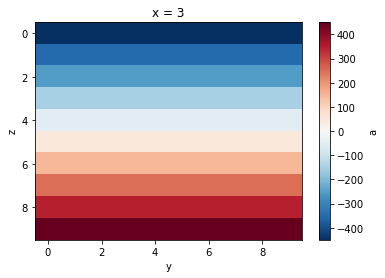

In [291]:
a = np.arange(10) - 4.5
a = np.tile(a, 100).reshape(10, 10, 10)

import xarray as xr

a = xr.DataArray(100*a, coords=[np.arange(10), np.arange(10), np.arange(10)], dims=['x', 'y', 'z'], name='a')

a[3].T.plot()
plt.gca().invert_yaxis()  # Must be a nicer way to do this in DataArray.plot()?

Love how `xarray` chooses a diverging colourmap when the data are diverging.

Now make a horizon... we'll make a random one. The numbers represent the z dimension of the 'seismic' cube:

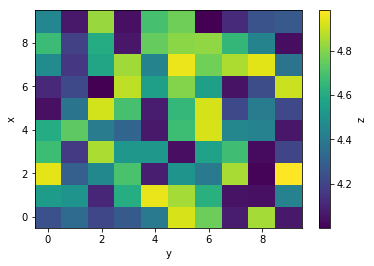

In [292]:
h = np.random.random((10,10)) + 4

h = xr.DataArray(h, coords=[np.arange(10), np.arange(10)], dims=['x', 'y'], name='z')

h.plot()

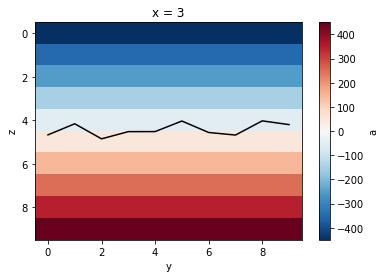

In [293]:
a[3].T.plot()
plt.plot(h[3], c='k')
plt.gca().invert_yaxis()

Now... the golden question... can we get the xarray to interpolate on its own??

In [294]:
amp = a.interp(x=h.x, y=h.y, z=h)

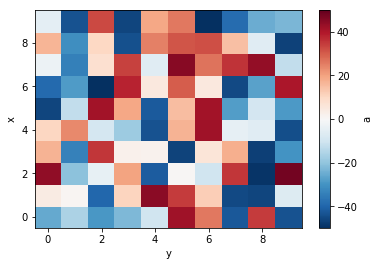

In [295]:
amp.plot()

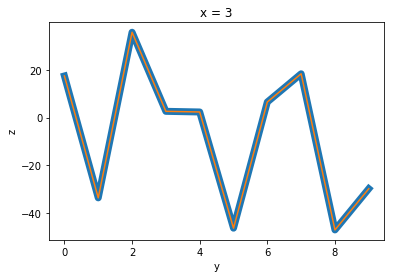

In [297]:
amp[3].plot(lw=7)
(100 * (h[3]-4.5)).plot()

Yes! It works... I think it would be nice if it magically mapped the x and y coordinates from the horizon, but the syntax was not too bad:

    amp = a.interp(x=h.x, y=h.y, z=h)
    
I would prefer:

    amp = a.interp(h)
    
Since the `name` of `h` is `z`, and the x and y coordinates are called that, this seems like it should be enough.

<hr />

# Real data

## Load the seismic data

**The seismic data is too big for GitHub. The easiest thing to do is to download the HDF5 file:**

-  https://s3.amazonaws.com/agilegeo/Penobscot.h5 (about 120MB)

**and put it into the `data` folder. Then you can just do this:**

In [252]:
import h5py
h5f = h5py.File('data/Penobscot.h5','r')
seismic_data = h5f['amplitude'][:]
h5f.close()

In [253]:
seismic_data.shape

(251, 601, 481)

In [254]:
import xarray as xr

t, x, i = seismic_data.shape
inlines = np.arange(i) + 1000
xlines  = np.arange(x) + 1000
tslices = np.arange(t) * 0.004

seismic = xr.DataArray(seismic_data,
                       name='Amplitude',
                       coords=[tslices, xlines, inlines],
                       dims=['twt', 'xlines', 'inlines'],
                       )

In [255]:
del seismic_data

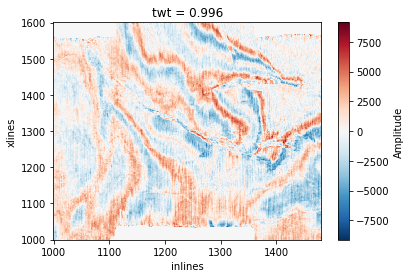

In [256]:
seismic.loc[0.996].plot()

## Load the horizon

We already have a horizon. Try this:

In [202]:
horizon_data = np.loadtxt('data/Penobscot_Seabed.txt')
horizon_data[-5:]

array([[1597.        , 1351.        ,  173.91996086],
       [1597.        , 1352.        ,  175.07746816],
       [1597.        , 1353.        ,  176.5011102 ],
       [1597.        , 1354.        ,  177.92794108],
       [1597.        , 1355.        ,  180.42777479]])

## Regularize horizon

We need to turn the horizon data, which is columnar, into a 2D array of TWT values.

So we'll read the 3rd column of the data into a new array, using the first two columns to tell us where to put the values.

In [231]:
def regularize_horizon(horizon, extents, adj=(0,0)):
    output = np.empty(extents)
    output[:] = np.nan
    adj_x, adj_y = adj
    for (x, y, z) in horizon:
        output[int(x+adj_x), int(y+adj_y)] = z
    return output

Now we can call this function on the columnar horizon data:

In [232]:
horizon_array = regularize_horizon(horizon_data,
                                   extents=seismic[0].shape,
                                   adj=(-1000, -1000))

We'll also turn the TWT values in the horizon into seconds, because that's what the seismic's vertical coordinate is:

In [233]:
horizon_array /= 1000

We can turn this into an xarray in a similar way to the seismic data:

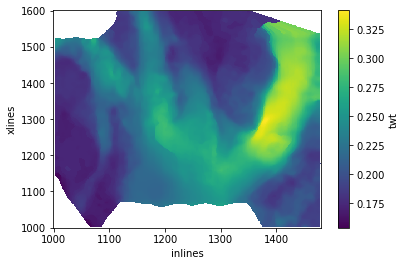

In [234]:
horizon = xr.DataArray(horizon_array,
                       name='twt',
                       coords=[xlines, inlines],
                       dims=['xlines', 'inlines'],
                       )

horizon.plot()

Apparently you cannot pass `aspect` to this plot method. If we wanted this plot to be linear in real-world space (rather than in inline/xline space) we'd have to fiddle with the plot dimensions, or use real-world coordinates in the `xarray.DataArray` in the first place.

## Plot datasets together

First let's plot the horizon on the seismic data:

In [235]:
line = 1300

As usual, it takes quite a bit of `matplotlib` code to put a nice figure together...

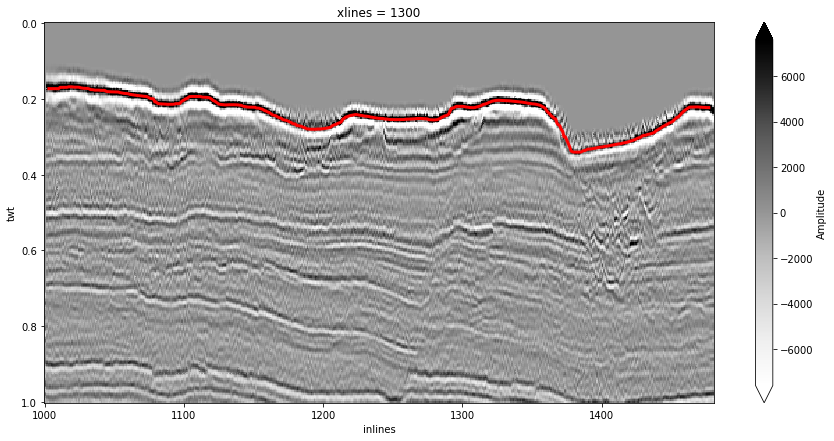

In [249]:
clip = np.percentile(seismic[200], 99.99)

plt.figure(figsize=(15,7))
seismic.sel(xlines=line).plot(cmap='Greys', vmin=-clip, vmax=clip)
horizon.sel(xlines=line).plot(color='red', lw=3)
plt.gca().invert_yaxis()

## Extract amplitude on entire horizon

Unfortunately, the interpolation trick doesn't work if there are NaNs in the horizon. It would be cool if it did... 

In [265]:
hor = horizon.fillna(0)

Now we can get the amplitude using `xarray`'s `interp` method:

In [278]:
amp = seismic.interp(inlines=hor.inlines,
                     xlines=hor.xlines,
                     twt=hor)

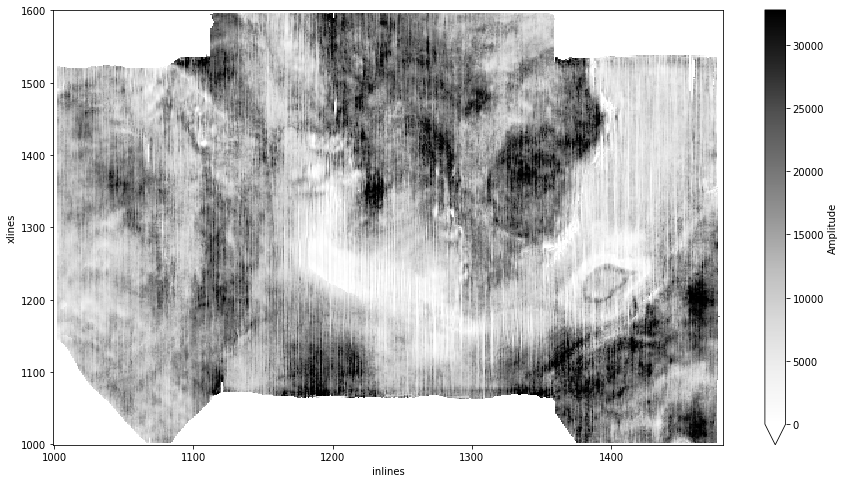

In [283]:
plt.figure(figsize=(15,8))
amp.plot(cmap='Greys', vmin=0)

<hr />
<img src="https://avatars1.githubusercontent.com/u/1692321?v=3&s=200" style="float:left;" width="50px" /><p style="color:gray; float:left; margin-left:12px;">Code and text © 2019 <a href="http://www.agilegeoscience.com/">Agile Geoscience</a> — <a href="https://creativecommons.org/licenses/by/4.0/">CC-BY</a> — Have fun!&nbsp;&nbsp;&nbsp;<br>Data: Penobscot, licensed CC-BY-SA, Nova Scotia Department of Energy https://opendtect.org/osr/. </p>